In [1]:
import numpy as np
import pandas as pd
import sys, os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from DOE_HER import load_data

stab_df = load_data.binary_echem_stabilities()
stab_df["Components"] = stab_df.chemsys.apply(
    lambda x: [(x[0], "X") if len(x) == 1 else x][0]
)
stab_df["mpid"] = stab_df.entry_id
stab_df = stab_df[stab_df.type == "solid"].drop("type", axis=1)

100%|██████████| 253/253 [00:00<00:00, 475.50it/s]


In [3]:
from matplotlib.pyplot import rc

rc("font", **{"family": "sans-serif", "sans-serif": ["Arial"]})

In [4]:
import ast


def safe_literal_eval(x):
    try:
        return ast.literal_eval(x)
    except:
        return None

In [5]:
ads_df = load_data.adsorption_energies()

In [6]:
stab_ads_df = stab_df.merge(ads_df, on="mpid")

In [7]:
lc_ads_df = (
    stab_ads_df.groupby(["Components", "mpid", "miller", "shift", "top"])
    .adsorption_energy_H.min()
    .reset_index()
)

In [8]:
exp_df = load_data.experimental_data()
exp_df["LogRate"] = exp_df.MaxRate.apply(np.log)

In [9]:
def choose_best(x, xopt=-0.24):
    x = np.array(x)
    x_dist = np.abs(xopt - x)
    return x[x_dist == min(x_dist)][0]

In [10]:
Au_Ni_df = stab_ads_df[stab_ads_df.Components == ("Au", "Ni")].copy()

In [11]:
Au_Ni_lc_df = lc_ads_df[lc_ads_df.Components == ("Au", "Ni")][
    ["mpid", "adsorption_energy_H"]
]

In [13]:
volcano_plot_df = (exp_df.groupby(["Components", "Concentrations"])
    .LogRate.mean()
    .reset_index()
    .groupby("Components")
    .LogRate.max()
    .reset_index()
    .merge(
        lc_ads_df.groupby("Components").aggregate(choose_best).reset_index(),
        on="Components",
    ))

/opt/conda/lib/python3.8/site-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


In [14]:
x_min = min([Au_Ni_lc_df.adsorption_energy_H.min(), volcano_plot_df.adsorption_energy_H.min()])
x_max = max([Au_Ni_lc_df.adsorption_energy_H.max(), volcano_plot_df.adsorption_energy_H.max()])
x_buffer = (x_max-x_min)*0.05
x_min = x_min - x_buffer
x_max = x_max + x_buffer

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


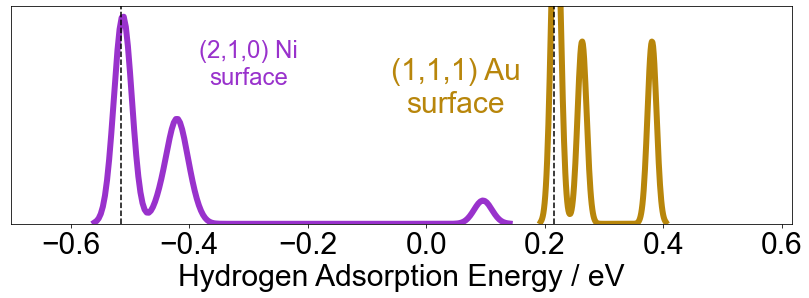

In [15]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.autoscale(True)
sns.kdeplot(
    data=Au_Ni_df[
        (Au_Ni_df.mpid == "mp-23")
        & (Au_Ni_df.miller == (2, 1, 0))
        & (Au_Ni_df["shift"].round(4) == 0.0833)
        & (Au_Ni_df.top)
    ].adsorption_energy_H,
    ax=ax,
    bw=0.1,
    c="darkorchid",
    linewidth=6,
)

sns.kdeplot(
    data=Au_Ni_df[
        (Au_Ni_df.mpid == "mp-81") & (Au_Ni_df.miller == (1, 1, 1)) & (Au_Ni_df.top)
    ].adsorption_energy_H,
    ax=ax,
    bw=0.1,
    c="darkgoldenrod",
    linewidth=6,
)
ax.autoscale(False, axis="y")
ax.plot(
    (
        2
        * (
            Au_Ni_df[
                (Au_Ni_df.mpid == "mp-81")
                & (Au_Ni_df.miller == (1, 1, 1))
                & (Au_Ni_df.top)
            ].adsorption_energy_H.min(),
        )
    ),
    (0, 55),
    c="k",
    ls="--",
)
ax.plot(
    (
        2
        * (
            Au_Ni_df[
                (Au_Ni_df.mpid == "mp-23")
                & (Au_Ni_df.miller == (2, 1, 0))
                & (Au_Ni_df.top)
            ].adsorption_energy_H.min(),
        )
    ),
    (0, 55),
    c="k",
    ls="--",
)
ax.text(
    0.05,
    8,
    "(1,1,1) Au\nsurface",
    color="darkgoldenrod",
    fontsize=30,
    ha="center",
)
ax.text(-0.3, 10, "(2,1,0) Ni\nsurface", color="darkorchid", fontsize=24, ha="center")
plt.xlabel("Hydrogen Adsorption Energy / eV", fontsize=30)
ax.set_ylabel("")
ax.set_yticks([])
plt.xticks(fontsize=30)
ax.set_xlim(x_min, x_max)
fig.savefig(
    "../figures/hierarchy_fig/AuNi_site_energies.png", bbox_inches="tight", dpi=300
)

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


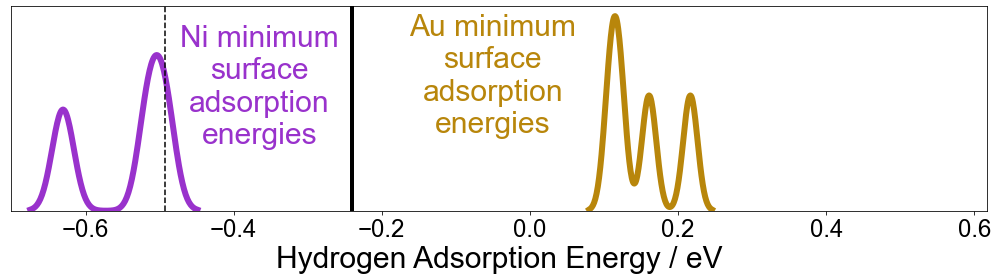

In [16]:
fig, ax = plt.subplots(figsize=(14, 4))
for mpid in Au_Ni_lc_df.mpid.unique():
    sns.kdeplot(
        data=Au_Ni_lc_df[Au_Ni_lc_df.mpid == mpid].adsorption_energy_H,
        ax=ax,
        label=mpid,
        bw=0.2,
        c=["darkorchid" if mpid == "mp-23" else "darkgoldenrod"][0],
        linewidth=6,
    )
ax.set_ylabel("")
ax.set_yticks([])
plt.xticks(fontsize=18)
ax.autoscale(False)
ax.plot(
    (
        2
        * (
            Au_Ni_lc_df[
                Au_Ni_lc_df.adsorption_energy_H.transform(lambda x: np.abs(x + 0.24))
                == Au_Ni_lc_df.adsorption_energy_H.transform(
                    lambda x: np.abs(x + 0.24)
                ).min()
            ].adsorption_energy_H,
        )
    ),
    [0, 50],
    c="k",
    ls="--",
)
ax.plot([-0.24, -0.24], [-10, 50], "k-", linewidth=4)
ax.set_xlim(x_min, x_max)
ax.text(
    -0.05,
    7,
    "Au minimum\nsurface\nadsorption\nenergies",
    color="darkgoldenrod",
    fontsize=30,
    ha="center",
)
ax.text(
    -0.365,
    6,
    "Ni minimum\nsurface\nadsorption\nenergies",
    color="darkorchid",
    fontsize=30,
    ha="center",
)
plt.xlabel("Hydrogen Adsorption Energy / eV", fontsize=30)
plt.xticks(fontsize=24)
plt.tight_layout()
fig.savefig(
    "../figures/hierarchy_fig/AuNi_surface_energies.png", bbox_inches="tight", dpi=300
)

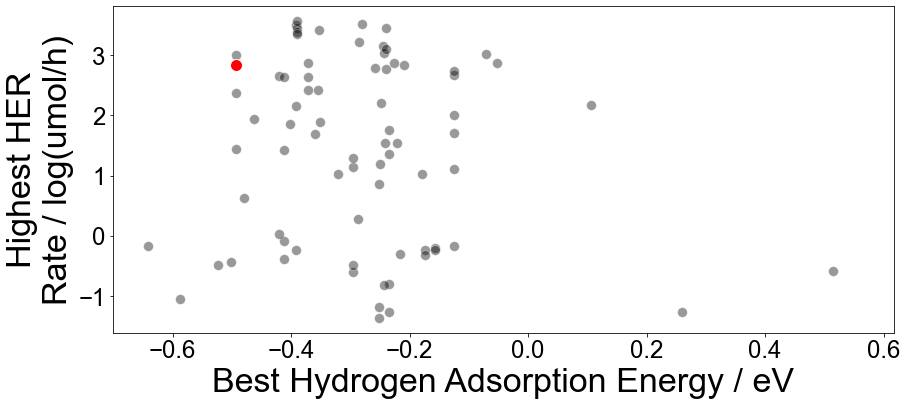

In [27]:
fig, ax = plt.subplots(figsize=(14, 6))
plot_df = volcano_plot_df
sns.scatterplot(
    data=plot_df,
    x="adsorption_energy_H",
    y="LogRate",
    color="black",
    s=96,
    alpha=0.4,
    ax=ax,
)
sns.scatterplot(
    data=plot_df[plot_df.Components == ("Au", "Ni")],
    x="adsorption_energy_H",
    y="LogRate",
    color="red",
    s=144,
    ax=ax,
)
ax.set_xlabel("Best Hydrogen Adsorption Energy / eV", fontsize=34)
ax.set_ylabel("Highest HER\nRate / log(umol/h)", fontsize=34)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
ax.set_xlim(x_min, x_max)
fig.savefig(
    "../figures/hierarchy_fig/tagged_example_volcano_%s.png",
    bbox_inches="tight",
    dpi=300,
)

In [18]:
Au_Ni_exp_df = exp_df[exp_df.Components == ("Au", "Ni")]

In [19]:
def plot_max_rate(curve, x_pre=1, x_post=1, y_low=None, y_up=None, diff_window=5):
    #    curve =  savgol_filter(data, window_length=7, polyorder=5)[:50]
    curve = gaussian_filter(data, sigma=2)
    dy = np.diff(curve)
    max_pos = np.argmax(dy)
    dy_max = np.amax(dy)
    x_plt = np.arange(max_pos - x_pre, max_pos + x_post)
    y = dy_max * (x_plt - max_pos) + curve[max_pos]
    if y_low != None:
        x_plt = x_plt[y > y_low]
        y = y[y > y_low]
    if y_up != None:
        x_plt = x_plt[y < y_up]
        y = y[y < y_up]
    return x_plt, y

In [20]:
from DOE_HER import utils

In [21]:
import importlib

importlib.reload(utils)

<module 'DOE_HER.utils' from '/home/jovyan/DOE_HER/DOE_HER/utils.py'>

In [22]:
Au_Ni_exp_df = pd.read_json("../figures/hierarchy_fig//AuNi_plate_data.json")

In [23]:
exp_df[exp_df.Components == ("Au", "Ni")].path.unique()

array(['/content/drive/Shareddrives/h2-data-science/data/generation-2/02/NicolAurow',
       '/content/drive/Shareddrives/h2-data-science/data/generation-2/03/AucolNirow',
       '/content/drive/Shareddrives/h2-data-science/data/generation-2/03/NicolAurow'],
      dtype=object)

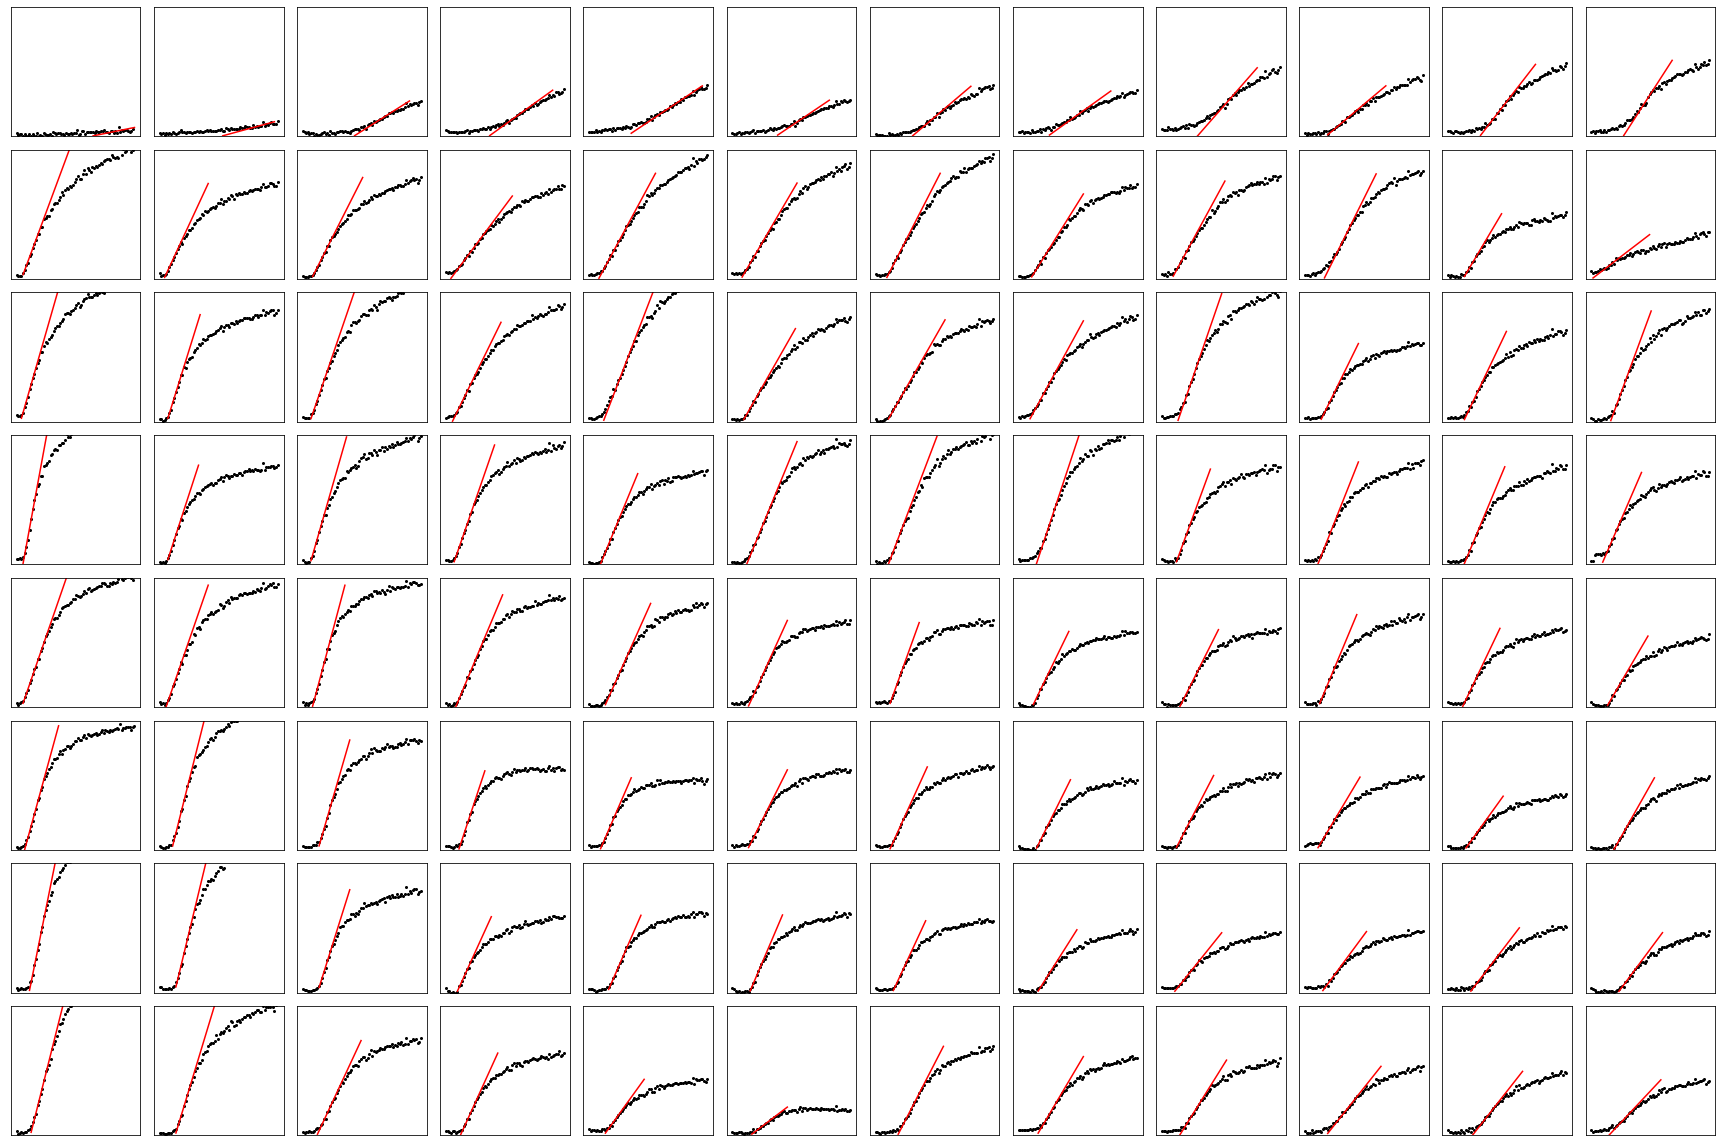

In [24]:
from scipy.ndimage import gaussian_filter

fig, axs = plt.subplots(
    8,
    12,
    figsize=(24, 16),
)
for row in range(8):
    for col in range(12):
        idx = 12 * row + col
        ax = axs[row][col]
        ax.set_xticks([])
        ax.set_yticks([])
        data = Au_Ni_exp_df.loc[idx, "('umolh', '')"]
        ax.plot(range(len(data)), data, "k.", markersize=4)
        ax.plot(
            *plot_max_rate(
                data, x_pre=25, x_post=25, y_low=0, y_up=max(data), diff_window=3
            ),
            "r"
        )
        ax.set_ylim(bottom=0, top=20)
plt.tight_layout(pad=1)
fig.savefig(
    "../figures/hierarchy_fig/AuNi_activity_grid.png", bbox_inches="tight", dpi=300
)

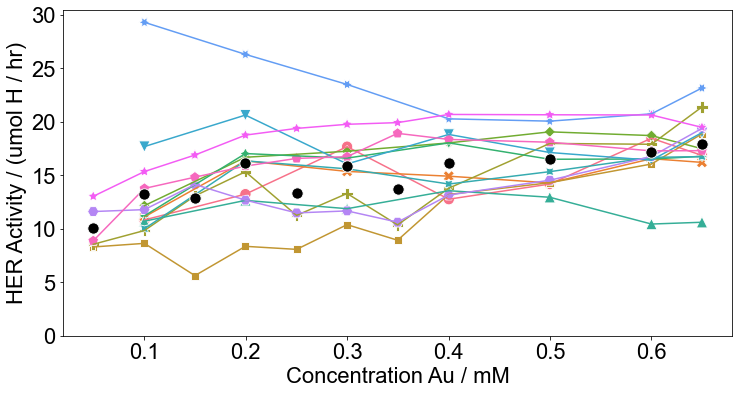

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
Au_df = exp_df[(exp_df.Components == ("Au", "X")) & (exp_df.Concentration_Au < 0.7)]
plot_df = Au_df.sort_values("path").reset_index(drop=True).copy()


sns.scatterplot(
    data=plot_df,
    x="Concentration_Au",
    y="MaxRate",
    style="path",
    hue="path",
    s=128,
    ax=ax,
    legend=False,
)
sns.lineplot(
    data=plot_df, x="Concentration_Au", y="MaxRate", hue="path", ax=ax, legend=False
)
sns.scatterplot(
    data=plot_df.groupby("Concentration_Au").MaxRate.mean().reset_index(),
    x="Concentration_Au",
    y="MaxRate",
    color="black",
    s=128,
    ax=ax,
    legend=False,
    zorder=3,
)
ax.set_xlabel("Concentration Au / mM", fontsize=22)
ax.set_ylabel("HER Activity / (umol H / hr)", fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
ax.autoscale(False)
ax.set_ylim(bottom=0)
fig.savefig("../figures/hierarchy_fig/Au_variability.png", bbox_inches="tight", dpi=300)

/tmp/ipykernel_251827/1606017891.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(projection="3d")


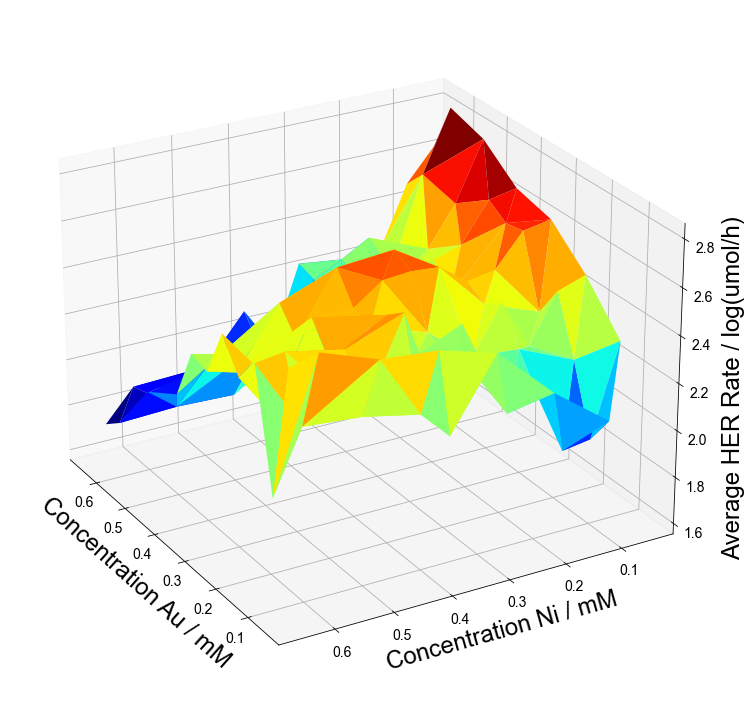

In [26]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca(projection="3d")
plot_df = exp_df[(exp_df.Components == ("Au", "Ni"))].reset_index(drop=True).copy()
plot_df = (
    plot_df.groupby(["Concentration_Au", "Concentration_Ni"])
    .LogRate.mean()
    .reset_index()
)
xx = plot_df.Concentration_Au
yy = plot_df.Concentration_Ni
zz = plot_df.LogRate
ax.plot_trisurf(
    plot_df.Concentration_Au, plot_df.Concentration_Ni, plot_df.LogRate, cmap=plt.cm.jet
)
ax.tick_params(axis="both", labelsize=14)

plt.xlabel("Concentration Au / mM", fontsize=24, labelpad=10)
plt.ylabel("Concentration Ni / mM", fontsize=24, labelpad=10)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel("Average HER Rate / log(umol/h)", fontsize=24, rotation=90, labelpad=10)
ax.view_init(25, 150)
plt.tight_layout()
fig.savefig(
    "../figures/hierarchy_fig/AuNi_surf_plot.png",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
    edgecolor="None",
)